In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/UNSW-NB15/UNSW_NB15_testing-set.csv')

data = pd.concat([train_df, test_df], ignore_index=True)

data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify the target variable
categorical_target = 'attack_cat'
binary_target = 'label'

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the target variable
if categorical_target in data.columns:
    data[categorical_target] = label_encoder.fit_transform(data[categorical_target])

# Apply label encoding to each categorical feature
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to numerical features excluding the target variables
features_to_scale = data.columns.difference([categorical_target, binary_target])
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM, MultiHeadAttention, GlobalAveragePooling1D



# Assume 'binary_target' and 'multi_class_target' are the names of the target variables
X = data.drop(columns=['label', 'attack_cat'])
y_binary = data['label']
y_multi_class = data['attack_cat']

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X, y_binary, and y_multi_class are already defined
X_train, X_test, y_train_binary, y_test_binary, y_train_multi_class, y_test_multi_class = train_test_split(
    X, y_binary, y_multi_class, test_size=0.2, random_state=42)

In [ ]:
# Check class distribution for the multi-class target variable
print(y_train_multi_class.value_counts())

attack_cat
6    74387
5    47334
3    35445
4    19415
2    13061
7    11135
0     2158
1     1861
8     1202
9      140
Name: count, dtype: int64


**Best_Accuracy- CNN+Bi-GRU with selected features([ 0, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18, 20, 24, 27, 28, 29, 31, 32, 34, 35, 36, 40, 41] with Epochs = 30, droupout = .01**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X, y_binary, and y_multi_class are already defined
# Convert to DataFrame if it's not already
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)

# Selected features indices
selected_features_indices = [ 0, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 16, 18, 20, 24, 27, 28, 29, 31, 32, 34, 35, 36, 40, 41]

# Extract the selected features using iloc
X_selected = X.iloc[:, selected_features_indices]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Reshape for Conv1D layer
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train_binary, y_test_binary, y_train_multi_class, y_test_multi_class = train_test_split(
    X_scaled, y_binary, y_multi_class, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, GRU, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

# Define the hybrid model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN for feature extraction
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.01)(x)

# Bidirectional GRU for sequence modeling
x = Bidirectional(GRU(50, return_sequences=True))(x)

# Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=2, key_dim=50)(x, x)
attention_output = Add()([x, attention_output])
attention_output = LayerNormalization()(attention_output)

# Flatten and Dense layers for classification
x = GlobalAveragePooling1D()(attention_output)
x = Dense(100, activation='relu')(x)
x = Dropout(0.01)(x)

# Output layers for binary and multi-class classification
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
multi_class_output = Dense(len(np.unique(y_train_multi_class)), activation='softmax', name='multi_class_output')(x)

# Define the model
Best_model2 = Model(inputs=input_layer, outputs=[binary_output, multi_class_output])

In [ ]:
# Compile the model
Best_model2.compile(optimizer='adam',
              loss={'binary_output': 'binary_crossentropy', 'multi_class_output': 'sparse_categorical_crossentropy'},
              metrics={'binary_output': 'accuracy', 'multi_class_output': 'accuracy'})

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_path = '/content/drive/MyDrive/Saved_Model /CNN+BiGRU.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_acc', save_best_only=True, save_weights_only=False)

In [ ]:
# Train the model
history = Best_model2.fit(X_train, {'binary_output': y_train_binary, 'multi_class_output': y_train_multi_class},
                    epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
5154/5154 [==============================] - 159s 30ms/step - loss: 0.8504 - binary_output_loss: 0.1822 - multi_class_output_loss: 0.6682 - binary_output_accuracy: 0.9105 - multi_class_output_accuracy: 0.7484 - val_loss: 0.7038 - val_binary_output_loss: 0.1366 - val_multi_class_output_loss: 0.5671 - val_binary_output_accuracy: 0.9332 - val_multi_class_output_accuracy: 0.7784
Epoch 2/30
5154/5154 [==============================] - 140s 27ms/step - loss: 0.6814 - binary_output_loss: 0.1320 - multi_class_output_loss: 0.5494 - binary_output_accuracy: 0.9372 - multi_class_output_accuracy: 0.7907 - val_loss: 0.6310 - val_binary_output_loss: 0.1186 - val_multi_class_output_loss: 0.5124 - val_binary_output_accuracy: 0.9439 - val_multi_class_output_accuracy: 0.8000
Epoch 3/30
5154/5154 [==============================] - 142s 28ms/step - loss: 0.6078 - binary_output_loss: 0.1088 - multi_class_output_loss: 0.4990 - binary_output_accuracy: 0.9514 - multi_class_output_accuracy: 0.8120 - 

In [ ]:
Best_model2.save('/content/drive/MyDrive/Saved_Model /CNN+BiGRU.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the test set
y_pred_binary, y_pred_multi_class = Best_model2.predict(X_test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_confusion_matrix = confusion_matrix(y_test_multi_class, y_pred_multi_class)

# Print binary classification metrics
print(f'Binary Classification:')
print(f'Accuracy: {binary_accuracy}')
print(f'Precision: {binary_precision}')
print(f'Recall: {binary_recall}')
print(f'F1 Score: {binary_f1}')
print(f'Confusion Matrix:\n{binary_confusion_matrix}')

# Print multi-class classification metrics
print(f'\nMulti-Class Classification:')
print(f'Accuracy: {multi_class_accuracy}')
print(f'Precision: {multi_class_precision}')
print(f'Recall: {multi_class_recall}')
print(f'F1 Score: {multi_class_f1}')
print(f'Confusion Matrix:\n{multi_class_confusion_matrix}')

# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}




1611/1611 [==============================] - 14s 8ms/step
Binary Classification:
Accuracy: 0.9770253225962938
Precision: 0.98969326667901
Recall: 0.9741813984569588
F1 Score: 0.9818760715160422
Confusion Matrix:
[[18279   334]
 [  850 32072]]

Multi-Class Classification:
Accuracy: 0.8546230716988454
Precision: 0.8466406676047675
Recall: 0.8546230716988454
F1 Score: 0.8417688977989816
Confusion Matrix:
[[   74    21    44   267    80     0    33     0     0     0]
 [    0    36    40   283    90     2     7     9     1     0]
 [    3     1   670  2397   133    10    42    20    16     0]
 [   19     3   613  7661   385    34   146   193    25     1]
 [    3     1    68   395  3703     2   604    45    10     0]
 [    0     2    30   164    33 11282    16     8     1     1]
 [    7     0     2    40   230     0 18314    13     7     0]
 [    3     2    92   550    20     1    13  2170     1     0]
 [    0     0     4    64    57     0    35    22   127     0]
 [    0     0     0    26   

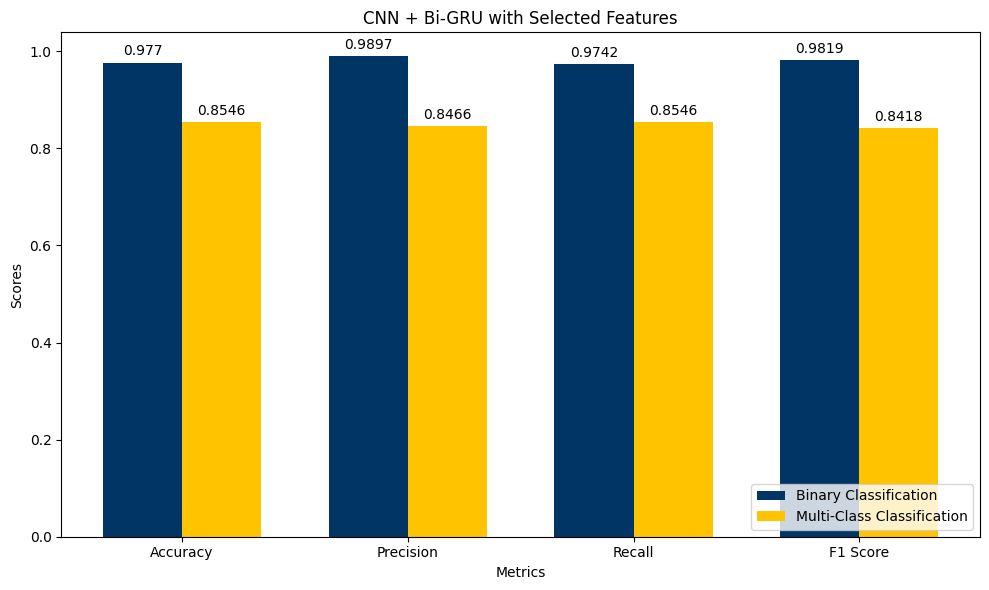

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='#003566')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='#ffc300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-GRU with Selected Features')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()